In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle
from scipy.stats import pearsonr

! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# from sklearn import svm

# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string

! pip install nltk
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

! pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
import io
import json
from collections import Counter


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Model Predictions

In [9]:
analysis_set = pd.read_csv("csv's/AnalysisDataset.csv")

In [10]:
reviews = analysis_set["cleanedText"]
reviews = reviews.apply(lambda x: re.sub(r"\s+", " ", str(x)).strip() if isinstance(x, (str, float, int)) else x)

In [11]:
unseen_reviews = []
for review in reviews:
    unseen_reviews.append(review)

In [12]:
with open('embedded.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [13]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_reviews)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [14]:
from keras.models import load_model

model_path = 'lstm_model.keras'
pretrained_lstm_model = load_model(model_path)
pretrained_lstm_model.summary()
preds = pd.Series()
preds = pretrained_lstm_model.predict(unseen_padded)
# unseen_sentiments

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     6,029,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,381,833 (24.34 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 6,029,700 (23.00 MB)

 Optimizer params: 234,756 (917.02 KB)

43426/43426 ━━━━━━━━━━━━━━━━━━━━ 679s 16ms/step


In [15]:
preds = (preds > 0.5).astype(int).flatten()

In [16]:
analysis_set["predictedSentiment"] = preds
analysis_set.head(1)

,Unnamed: 0,category,brand,item,rating,cleanedText,text_length,timestamp,numRating,average_rating,total_votes,predictedSentiment
0,0,All Beauty,herbivore,Herbivore - Natural Sea Mist Texturizing Salt ...,5.0,spray really nice smell really good go really ...,61,2020-05-05 14:08:48.923,384.0,4.3,0,1


In [ ]:
analysis_set.to_csv("csv's/Predictions.csv")

# Custom Metric for category popularity

In [174]:
df = pd.DataFrame()
df = pd.read_csv("csv's/Predictions.csv")

In [175]:
alpha = 0.7
beta = 0.25
gamma = 0.05

In [176]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

In [177]:
df.head(2)

,Unnamed: 0.1,Unnamed: 0,category,brand,item,rating,cleanedText,text_length,timestamp,numRating,average_rating,total_votes,predictedSentiment,month,year
0,0,0,All Beauty,herbivore,Herbivore - Natural Sea Mist Texturizing Salt ...,5.0,spray really nice smell really good go really ...,61,2020-05-05 14:08:48.923,384.0,4.3,0,1,5,2020
1,1,1,All Beauty,two goat apothecary,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,product need wish odorless soft coconut smell ...,47,2020-05-04 18:10:55.070,56.0,4.0,1,0,5,2020


In [178]:
cps_vals = {}

In [179]:
for category in df['category'].unique():

    category_data = df[df['category']==category]

    positive_sentiment_sum = category_data['predictedSentiment'].sum()
    prods_per_category = category_data['numRating'].count()

    # print(f"row count in category is: {prods_per_category}")

    sentiment_ratio = positive_sentiment_sum / prods_per_category
    # print(f"{category} sentiment ratio is: {sentiment_ratio}")

    positive_popularity = 0

    if sentiment_ratio > 0.5: 
        positive_popularity = 1

    for year in category_data['year'].unique():
        for month in category_data['month'].unique():
            category_by_year_month = category_data[(category_data["year"]==year) & (category_data["month"]==month)]
            
            if not category_by_year_month.empty:
                monthly_total_reviews = category_by_year_month["numRating"].sum()
                monthly_total_average_rating = category_by_year_month["average_rating"].sum()
                monthly_total_votes = category_by_year_month["total_votes"].sum()

                cps = ((alpha * monthly_total_reviews) +
                        (beta * monthly_total_average_rating) +
                        (gamma * monthly_total_votes))
                
                cps_vals[(category, year, month)] = cps * positive_popularity

In [180]:
df.loc[:, 'CPS'] = df.apply(
    lambda row: cps_vals.get((row['category'], row['year'], row['month']), 0),
    axis=1
)

In [181]:
cps_summary = pd.DataFrame([(cat, yr, mo, val) 
                           for (cat, yr, mo), val in cps_vals.items()],
                           columns=['category', 'year', 'month', 'CPS'])

In [182]:
cps_summary = cps_summary.sort_values(['year', 'month', 'category'])

In [183]:
cps_summary["CPS"] = np.log(cps_summary["CPS"])
min_val = cps_summary["CPS"].min()
max_val = cps_summary["CPS"].max()
cps_summary["CPS scaled"] = 0 + (cps_summary["CPS"] - min_val) * (100 - 0) / (max_val - min_val)

In [184]:
df["CPS"] = np.log(df["CPS"])
min_val = df["CPS"].min()
max_val = df["CPS"].max()
df["CPS scaled"] = 0 + (df["CPS"] - min_val) * (100 - 0) / (max_val - min_val)

In [185]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,category,brand,item,rating,cleanedText,text_length,timestamp,numRating,average_rating,total_votes,predictedSentiment,month,year,CPS,CPS scaled
0,0,0,All Beauty,herbivore,Herbivore - Natural Sea Mist Texturizing Salt ...,5.0,spray really nice smell really good go really ...,61,2020-05-05 14:08:48.923,384.0,4.3,0,1,5,2020,14.979877,78.704656
1,1,1,All Beauty,two goat apothecary,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,product need wish odorless soft coconut smell ...,47,2020-05-04 18:10:55.070,56.0,4.0,1,0,5,2020,14.979877,78.704656
2,2,2,All Beauty,new road beauty,New Road Beauty - Creamsicle - Variety 3 Pack ...,5.0,smell good feel great,4,2020-05-16 21:41:06.052,699.0,4.4,2,1,5,2020,14.979877,78.704656


# Top 5 categories by maximum CPS value

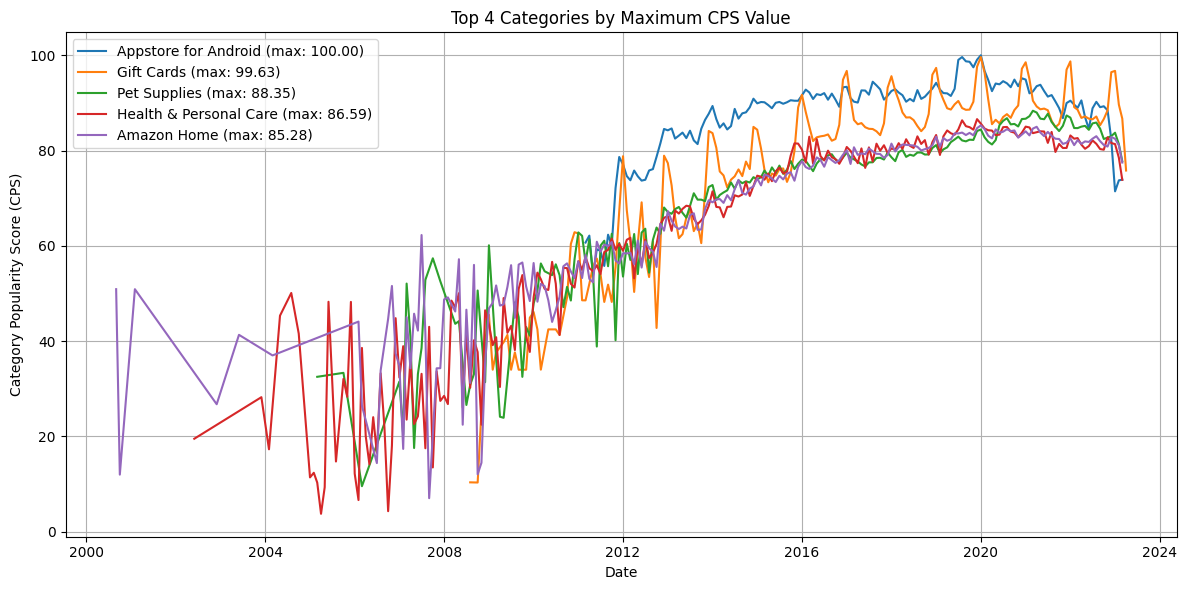

In [ ]:
max_cps_by_category = cps_summary.groupby('category')['CPS scaled'].max().sort_values(ascending=False)
top_categories = max_cps_by_category.head(5).index.tolist()

plt.figure(figsize=(12, 6))
for category in top_categories:
    category_subset = cps_summary[cps_summary['category'] == category].copy()
    category_subset.loc[:, 'date'] = pd.to_datetime(
        category_subset[['year', 'month']].assign(day=1)
    )
    plt.plot(category_subset['date'], category_subset['CPS scaled'], label=f"{category} (max: {max_cps_by_category[category]:.2f})")

plt.xlabel('Date')
plt.ylabel('Category Popularity Score (CPS)')
plt.title('Top 5 Categories by Maximum CPS Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

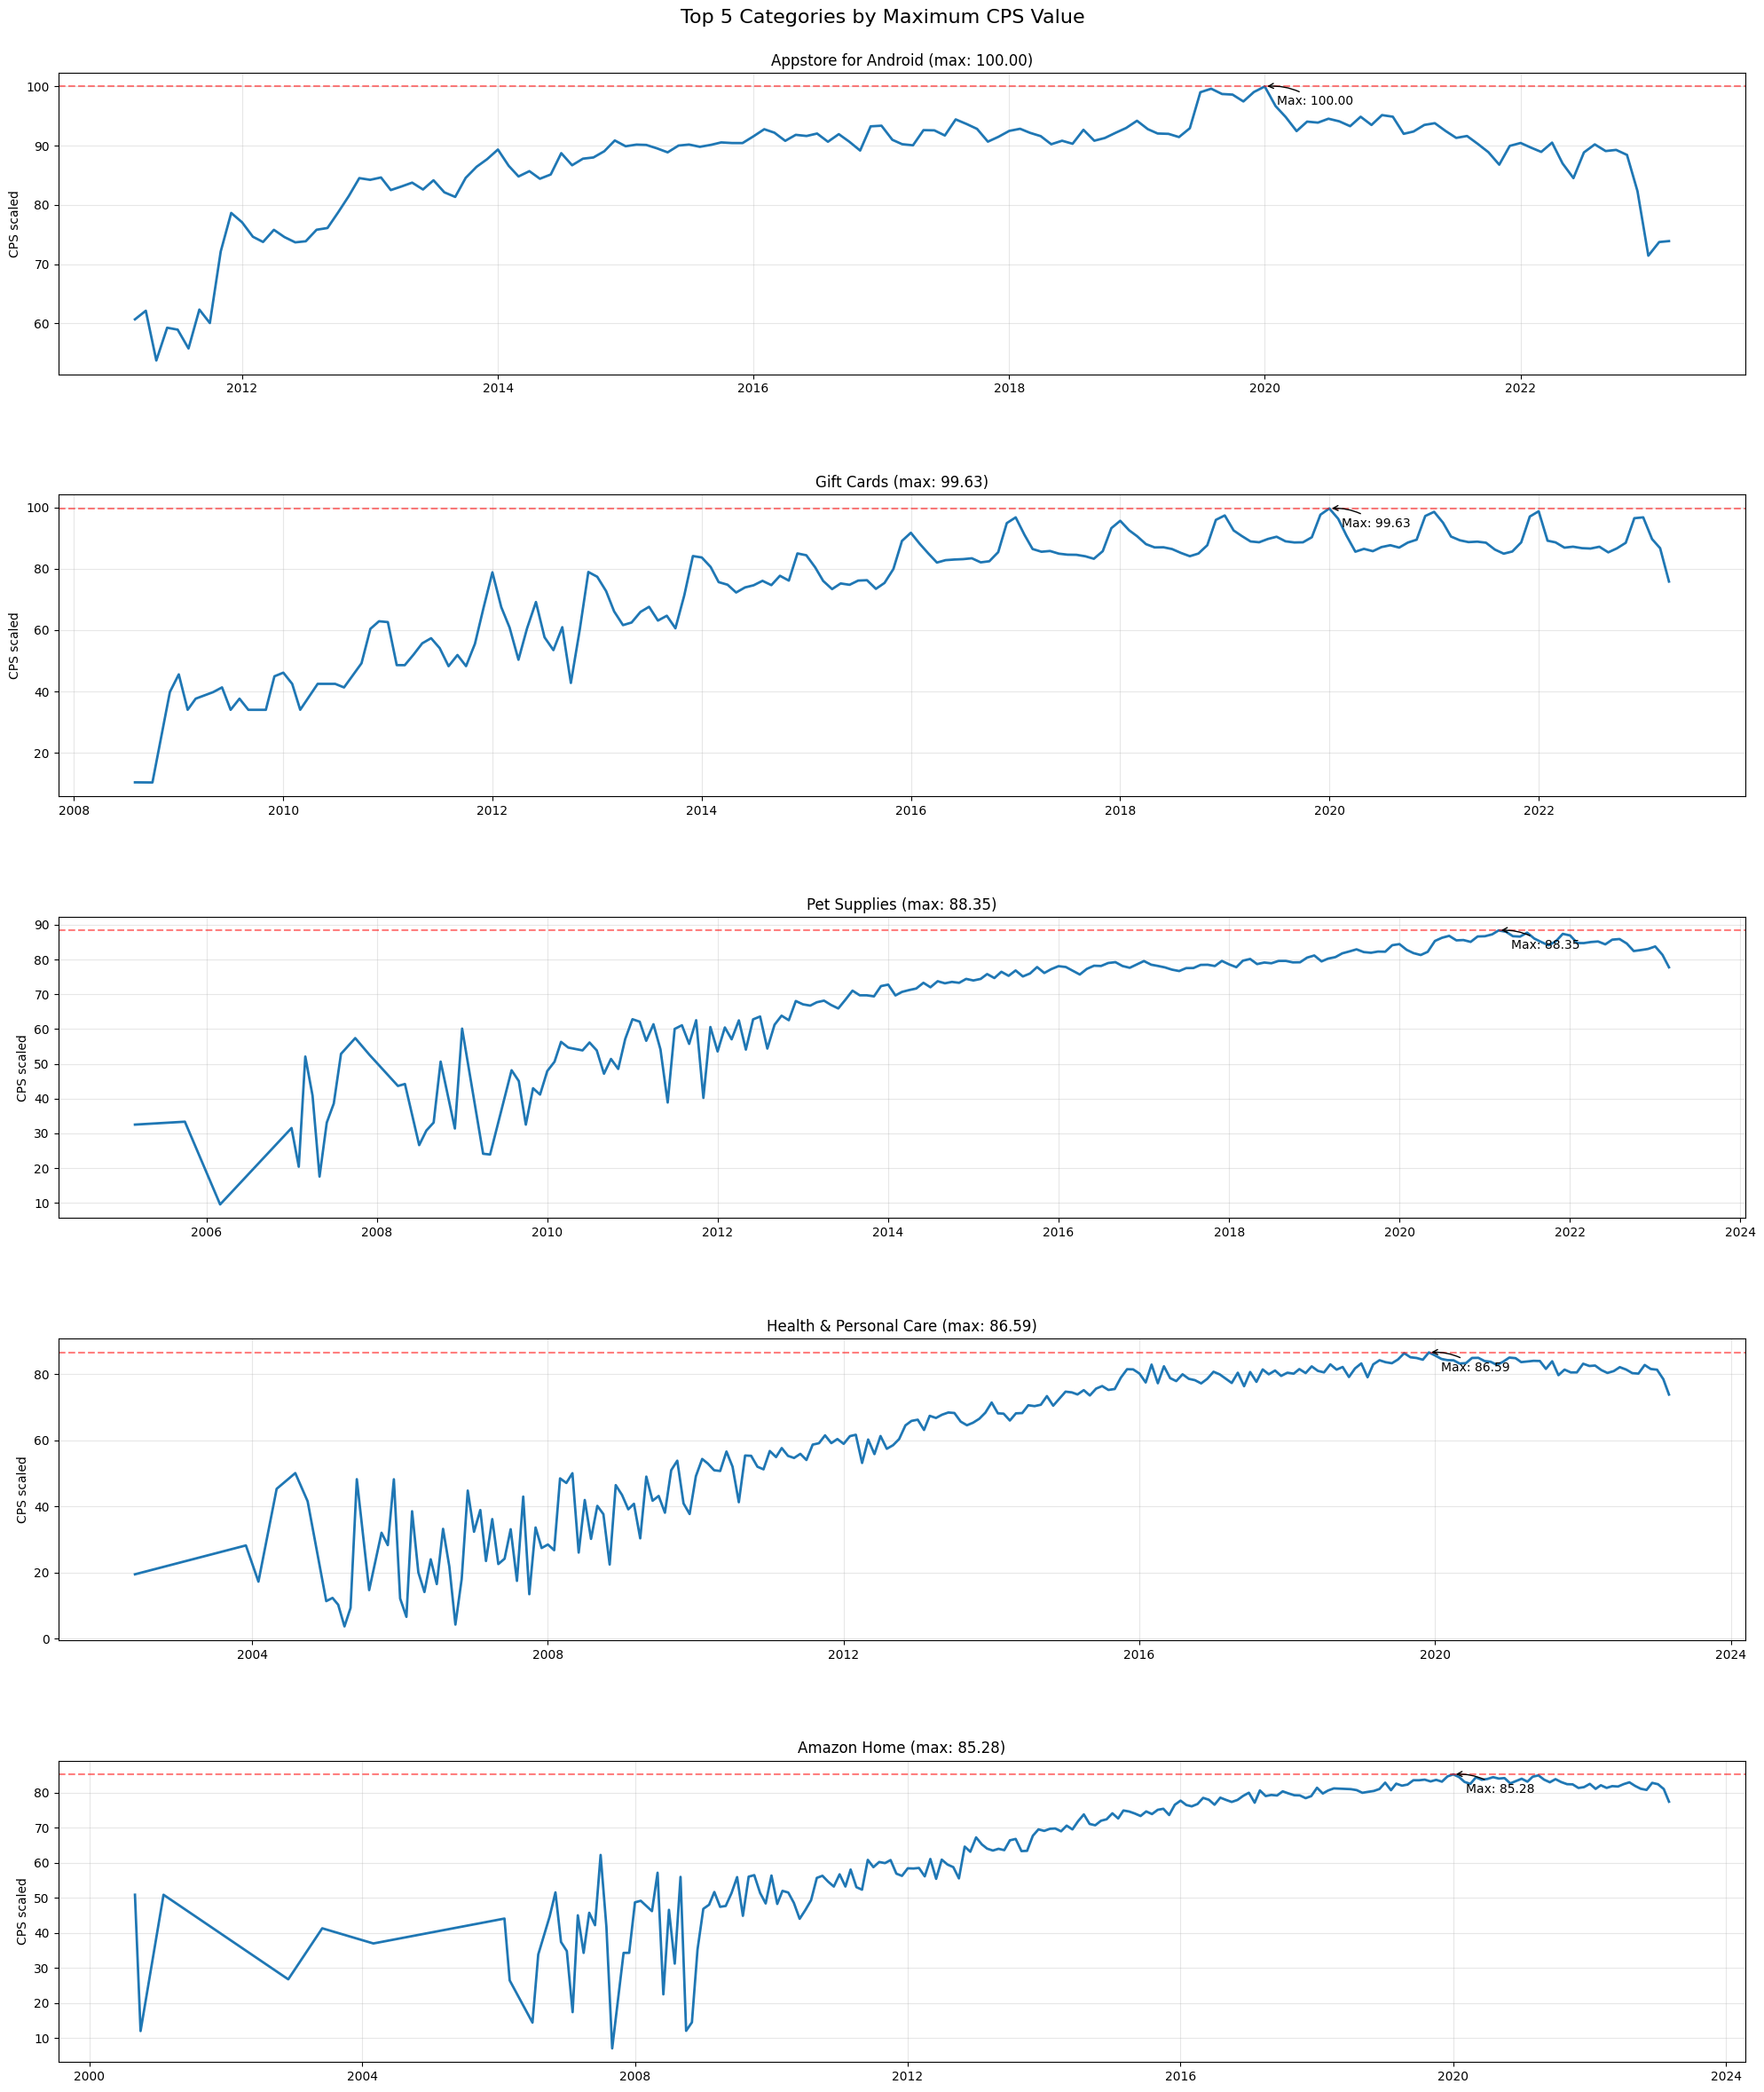

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get the top 5 categories by maximum CPS value
max_cps_by_category = cps_summary.groupby('category')['CPS scaled'].max().sort_values(ascending=False)
top_categories = max_cps_by_category.head(5).index.tolist()

# Create a figure with 5 subplots (one for each category)
fig, axes = plt.subplots(5, 1, figsize=(20, 24), sharex=False)
fig.suptitle('Top 5 Categories by Maximum CPS Value', fontsize=16)

# Plot each category in its own subplot
for i, category in enumerate(top_categories):
    category_subset = cps_summary[cps_summary['category'] == category].copy()
    category_subset.loc[:, 'date'] = pd.to_datetime(
        category_subset[['year', 'month']].assign(day=1)
    )
    
    axes[i].plot(category_subset['date'], category_subset['CPS scaled'], 
                 linestyle='-', linewidth=2)
    
    # Add horizontal line for the maximum value
    max_value = max_cps_by_category[category]
    axes[i].axhline(y=max_value, color='r', linestyle='--', alpha=0.5)
    
    # Set category title and y label
    axes[i].set_title(f"{category} (max: {max_value:.2f})")
    axes[i].set_ylabel('CPS scaled')
    axes[i].grid(True, alpha=0.3)
    
    # Find the date of maximum CPS for annotation
    max_date = category_subset.loc[category_subset['CPS scaled'].idxmax(), 'date']
    axes[i].annotate(f"Max: {max_value:.2f}",
                    xy=(max_date, max_value),
                    xytext=(10, -15),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Set common figure properties
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)  # Increased spacing between subplots
plt.show()

# Top 5 categories by greatest growth

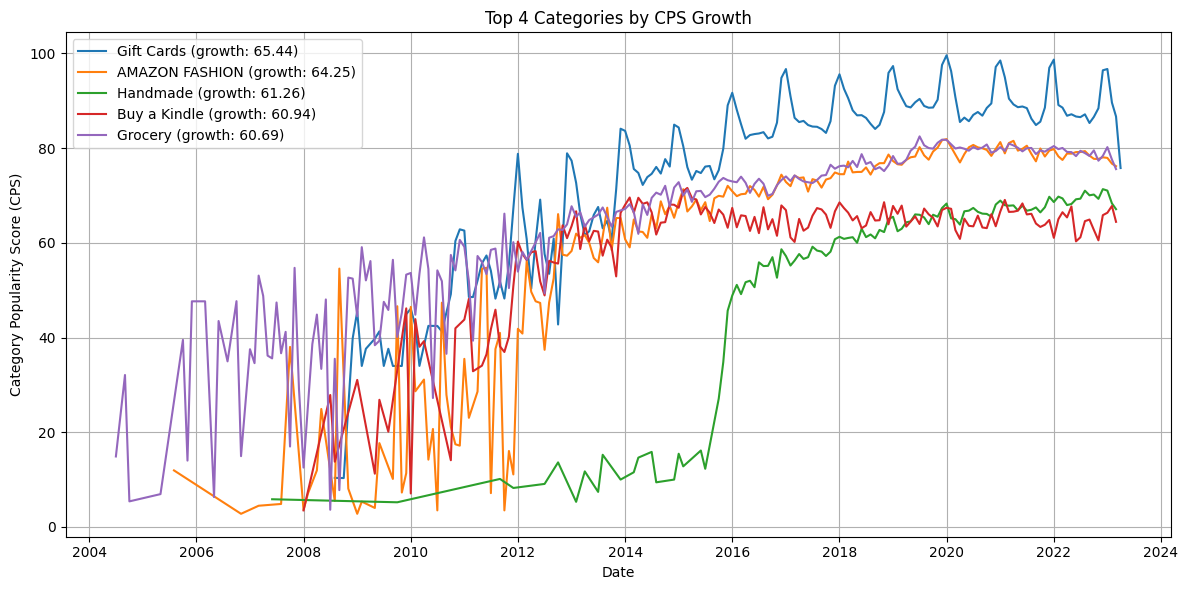

In [187]:
growth_by_category = {}
    
for category in cps_summary['category'].unique():
    category_data = cps_summary[cps_summary['category'] == category].sort_values(['year', 'month'])
    if len(category_data) >= 2:  # Need at least 2 data points to calculate growth
        first_cps = category_data['CPS scaled'].iloc[0]
        last_cps = category_data['CPS scaled'].iloc[-1]
        growth = last_cps - first_cps
        growth_by_category[category] = growth

# Get top 4 categories by growth
top_growth_categories = sorted(growth_by_category.items(), key=lambda x: x[1], reverse=True)[:5]
top_categories = [cat for cat, _ in top_growth_categories]

plt.figure(figsize=(12, 6))
for category in top_categories:
    category_subset = cps_summary[cps_summary['category'] == category].copy()
    category_subset.loc[:, 'date'] = pd.to_datetime(
        category_subset[['year', 'month']].assign(day=1)
    )
    plt.plot(category_subset['date'], category_subset['CPS scaled'], 
                label=f"{category} (growth: {growth_by_category[category]:.2f})")

plt.xlabel('Date')
plt.ylabel('Category Popularity Score (CPS)')
plt.title('Top 4 Categories by CPS Growth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

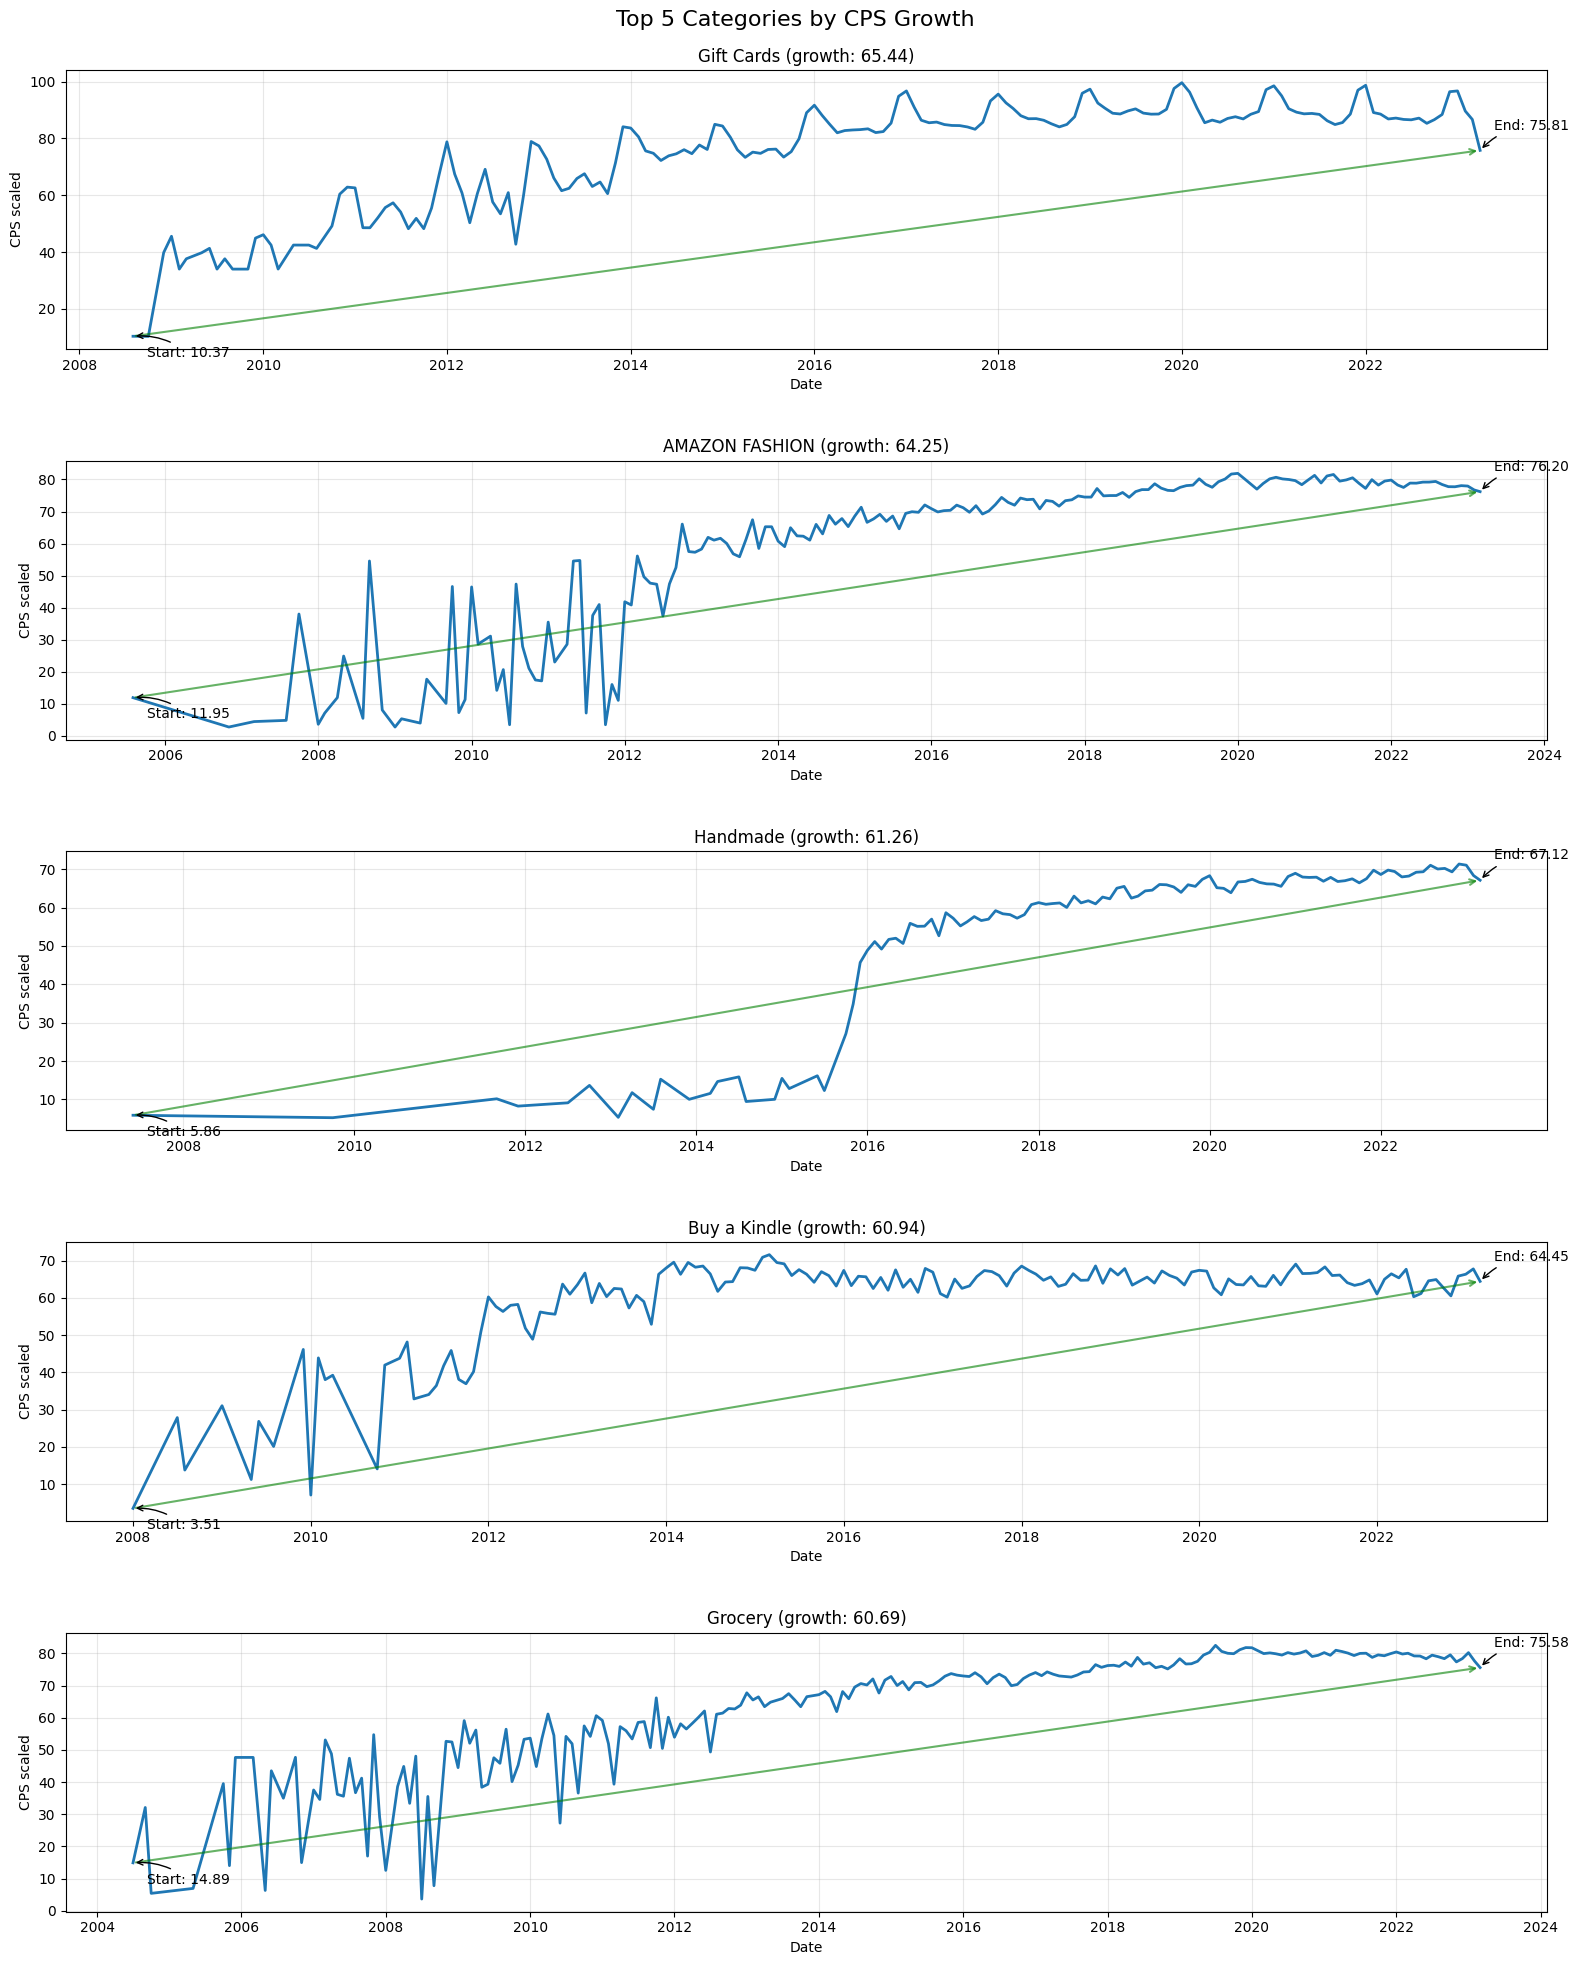

In [195]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate growth for each category
growth_by_category = {}
    
for category in cps_summary['category'].unique():
    category_data = cps_summary[cps_summary['category'] == category].sort_values(['year', 'month'])
    if len(category_data) >= 2:  # Need at least 2 data points to calculate growth
        first_cps = category_data['CPS scaled'].iloc[0]
        last_cps = category_data['CPS scaled'].iloc[-1]
        growth = last_cps - first_cps
        growth_by_category[category] = growth

# Get top 5 categories by growth
top_growth_categories = sorted(growth_by_category.items(), key=lambda x: x[1], reverse=True)[:5]
top_categories = [cat for cat, _ in top_growth_categories]

# Create a figure with 5 subplots (one for each category)
fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=False)
fig.suptitle('Top 5 Categories by CPS Growth', fontsize=16)

# Plot each category in its own subplot
for i, category in enumerate(top_categories):
    category_subset = cps_summary[cps_summary['category'] == category].copy()
    category_subset.loc[:, 'date'] = pd.to_datetime(
        category_subset[['year', 'month']].assign(day=1)
    )
    
    axes[i].plot(category_subset['date'], category_subset['CPS scaled'], 
                 linestyle='-', linewidth=2)
    
    # Show the growth with a line from first to last point
    first_date = category_subset['date'].iloc[0]
    last_date = category_subset['date'].iloc[-1]
    first_cps = category_subset['CPS scaled'].iloc[0]
    last_cps = category_subset['CPS scaled'].iloc[-1]
    
    # Add a subtle arrow showing the growth
    axes[i].annotate("", 
                    xy=(last_date, last_cps), 
                    xytext=(first_date, first_cps),
                    arrowprops=dict(arrowstyle="->", color="green", lw=1.5, alpha=0.6),
                    annotation_clip=False)
    
    # Set category title and labels
    growth = growth_by_category[category]
    axes[i].set_title(f"{category} (growth: {growth:.2f})")
    axes[i].set_ylabel('CPS scaled')
    axes[i].set_xlabel('Date')  # Add x-label to each subplot
    axes[i].grid(True, alpha=0.3)
    
    # Annotate the first and last points
    axes[i].annotate(f"Start: {first_cps:.2f}",
                    xy=(first_date, first_cps),
                    xytext=(10, -15),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
    
    axes[i].annotate(f"End: {last_cps:.2f}",
                    xy=(last_date, last_cps),
                    xytext=(10, 15),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Set common figure properties
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)  # Increased spacing between subplots
plt.show()

# Small multiples - show individual plots for top categories
Overall Patterns

Long-term Growth Trend: All five categories show a strong upward trajectory from early 2000s to around 2020-2022, with CPS values generally increasing from low values (0-20) to high values (70-80).
Recent Plateau/Decline: Interestingly, all categories show a slight decline or plateau after reaching their peaks around 2020-2022, suggesting a potential market correction or saturation.
Two Distinct Phases: Most categories exhibit an early phase of high volatility and lower values (2000-2014), followed by a more stable growth phase with higher values (2015-2023).

Category-Specific Insights

Amazon Fashion (highest volatility, std: 24.85):

Shows extreme volatility in the early period (2005-2012) with dramatic spikes and drops
Most unstable pricing among all categories
Stabilized significantly after 2014, showing steady growth thereafter
Peak CPS around 2020-2021


Health & Personal Care (std: 23.29):

Second most volatile category
Shows erratic behavior in early years similar to Amazon Fashion
Reached peak values slightly later than other categories
More jagged fluctuations throughout its growth phase compared to others


Handmade (std: 21.59):

Shows the most dramatic shift in the dataset
Had minimal data and low CPS values until around 2014-2015
Then experienced an extremely steep rise
This suggests this might be a newer category that was established or tracked later than others


All Electronics (std: 20.98):

Shows consistent volatility throughout the timeline
Has more frequent small ups and downs even during its growth phase
Technology pricing tends to fluctuate based on release cycles and market competition


All Beauty (std: 20.61):

Shows similar patterns to Amazon Fashion and Health & Personal Care
Relatively high early volatility that stabilizes into steady growth
Peaks around the same time as other categories (2020-2022)



Key Observations

Synchronous Peaks: All five categories reached their maximum CPS values around the same time period (2020-2022), suggesting a broader market factor affecting all categories simultaneously (possibly pandemic-related consumer behavior).
Consistent Low Points: The minimum values for most categories occurred in the early time periods (2005-2007), indicating either initial market entry or data collection differences.
Volatility Reduction: All categories show significantly reduced volatility after 2015, suggesting market maturation or improved pricing strategies.
Potential COVID Impact: The data appears to show peaks during the COVID-19 pandemic period (2020-2022), which aligns with known increases in e-commerce activity during lockdowns.
Category Emergence: The Handmade category shows a distinct pattern that suggests it was introduced to the platform much later than other categories, with minimal data before 2014-2015.


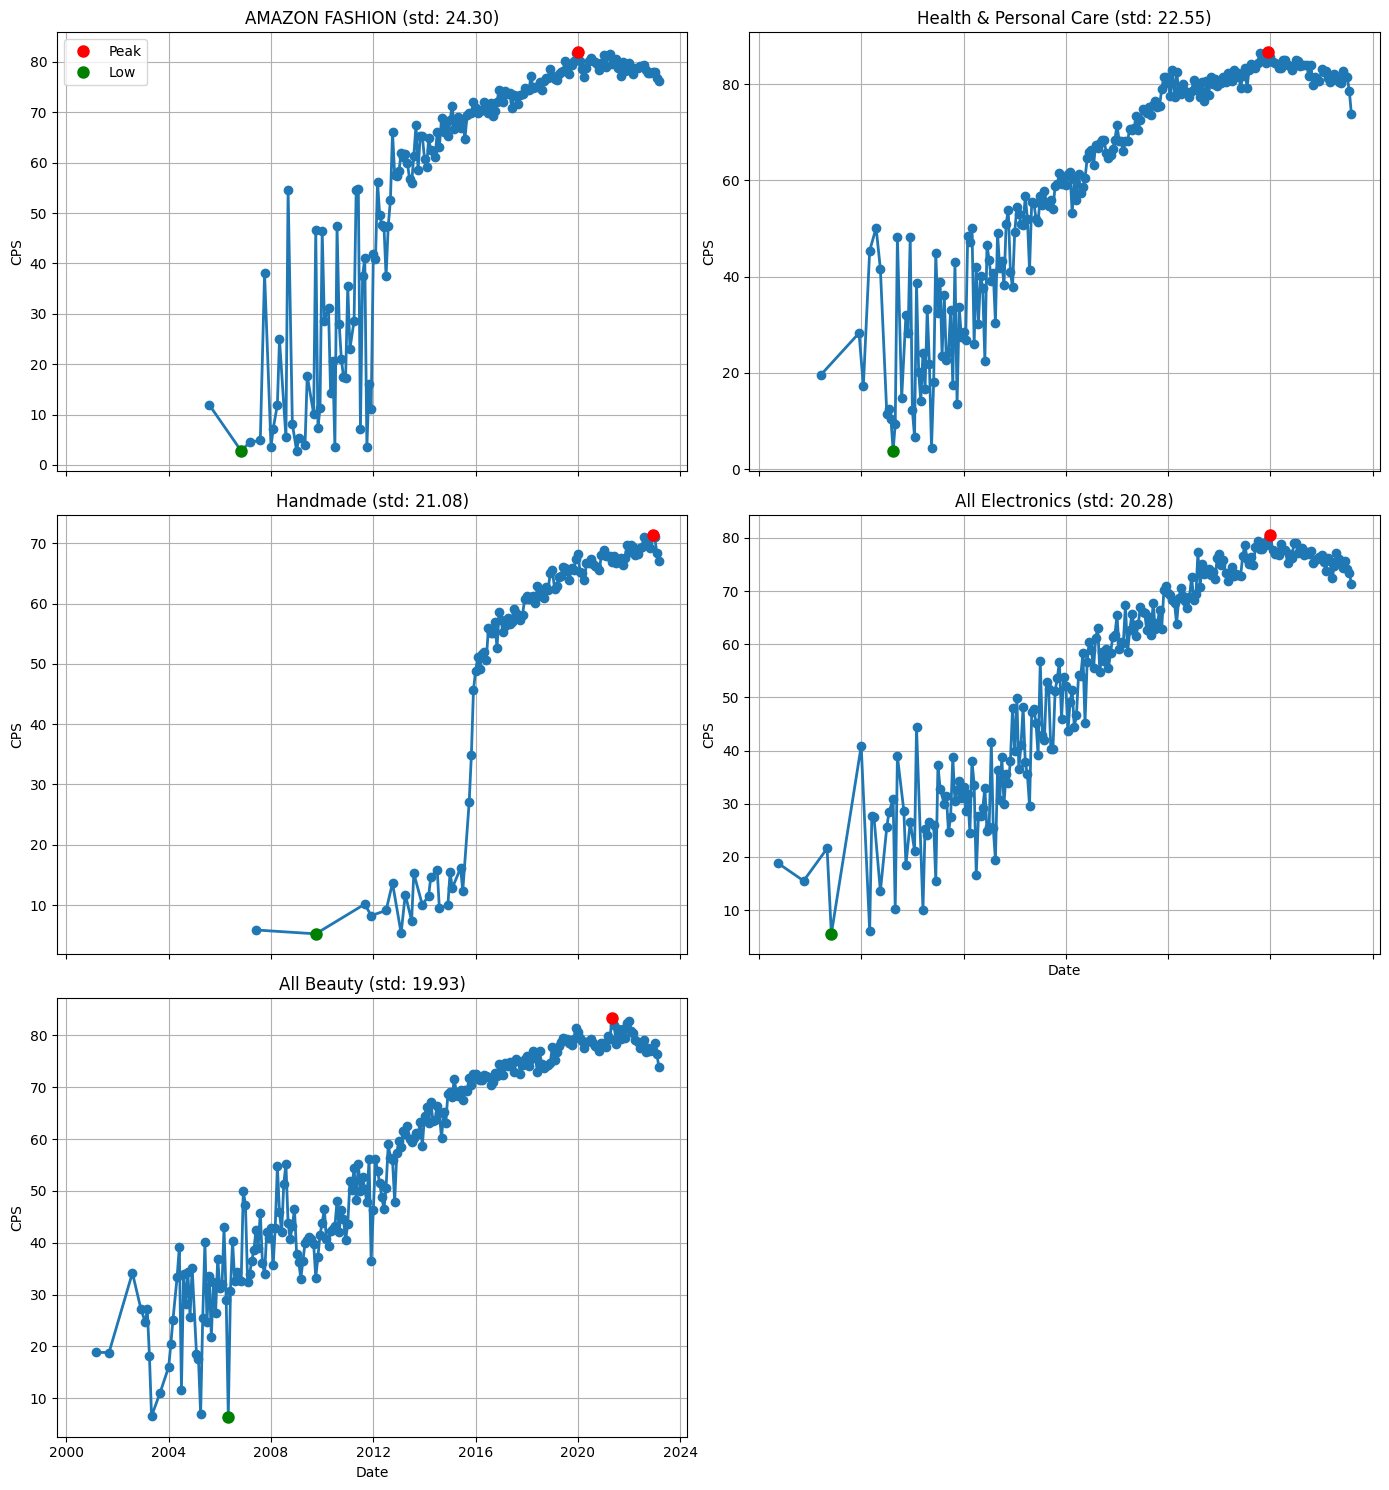

In [188]:
category_fluctuations = {}
for category in cps_summary['category'].unique():
    category_subset = cps_summary[cps_summary['category'] == category]
    fluctuation = category_subset['CPS scaled'].std()
    category_fluctuations[category] = fluctuation

# Get top 5 categories
top_categories = sorted(category_fluctuations.items(), key=lambda x: x[1], reverse=True)[:5]
top_category_names = [cat for cat, _ in top_categories]

# Create a 3x2 grid of subplots (6 total, we'll use 5)
fig, axes = plt.subplots(3, 2, figsize=(14, 15), sharex=True)
axes = axes.flatten()

for i, category in enumerate(top_category_names):
    category_subset = cps_summary[cps_summary['category'] == category].copy()
    category_subset.loc[:, 'date'] = pd.to_datetime(
        category_subset[['year', 'month']].assign(day=1)
    )
    
    axes[i].plot(category_subset['date'], category_subset['CPS scaled'], 
                marker='o', linestyle='-', linewidth=2)
    axes[i].set_title(f"{category} (std: {category_fluctuations[category]:.2f})")
    axes[i].set_ylabel('CPS')
    axes[i].grid(True)
    
    # Highlight min and max points
    max_idx = category_subset['CPS scaled'].idxmax()
    min_idx = category_subset['CPS scaled'].idxmin()
    
    axes[i].plot(category_subset.loc[max_idx, 'date'], 
                category_subset.loc[max_idx, 'CPS scaled'], 
                'ro', markersize=8, label='Peak')
    
    axes[i].plot(category_subset.loc[min_idx, 'date'], 
                category_subset.loc[min_idx, 'CPS scaled'], 
                'go', markersize=8, label='Low')
    
    if i >= 3:  # Only add x-label to bottom row plots
        axes[i].set_xlabel('Date')
        
    if i == 0:  # Only add legend to first plot
        axes[i].legend()

# Hide the unused subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()